In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)

In [2]:
! ls /home/daic/VideoCaption/RecNet/data/MSVD/metadata

'MSR Video Description Corpus.csv'   train.csv		 valid.list
 test.csv			     train.list		 val_tokens.json
 test.list			     train_tokens.json
 test_tokens.json		     val.csv


In [3]:
! ls /home/daic/VideoCaption/RecNet/data/MSR-VTT/metadata

test.json		 total.json  train_val_videodatainfo.json
test.list		 train.json  valid.list
test_videodatainfo.json  train.list  val.json


# MSVD :
## original datas:

In [4]:
msvd_o = pd.read_csv('/home/daic/VideoCaption/RecNet/data/MSVD/metadata/MSR Video Description Corpus.csv')
msvd_o.head(10)

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,mv89psg6zh4,33,46,588702,unverified,55,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
1,mv89psg6zh4,33,46,588702,unverified,37,Slovene,Papagaj se umiva pod tekočo vodo v lijaku.
2,mv89psg6zh4,33,46,362812,unverified,11,Macedonian,папагал се бања
3,mv89psg6zh4,33,46,968828,unverified,84,German,Ein Wellensittich duscht unter einem Wasserhahn.
4,mv89psg6zh4,33,46,203142,unverified,14,Romanian,o pasare sta intr-o chiuveta.
5,mv89psg6zh4,33,46,984231,unverified,35,Romanian,Un papagal se spala intr-o chiuveta.
6,mv89psg6zh4,33,46,130914,unverified,24,Georgian,თუთიყურში რაკოინაში სველდება
7,mv89psg6zh4,33,46,130914,unverified,19,Georgian,თუთიყურში სველდება რაკოინაში
8,mv89psg6zh4,33,46,400189,unverified,23,Serbian,Papagaj se tušira u sudoperu.
9,mv89psg6zh4,33,46,589431,unverified,66,Serbian,Papagaj biva kvašen u sudoperi vodom koja curi...


## split and clean them by whose 'Language' is English

In [5]:
msvd_tr = pd.read_csv('/home/daic/VideoCaption/RecNet/data/MSVD/metadata/train.csv')
msvd_tr.head(10)

,Unnamed: 0,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
0,29,ZbzDGXEwtGc,6,15,550906,clean,24,English,a plane flying in the sky
1,30,ZbzDGXEwtGc,6,15,164462,clean,42,English,A commercial plane flying.
2,31,ZbzDGXEwtGc,6,15,155632,clean,51,English,A jet is flying.
3,32,ZbzDGXEwtGc,6,15,617730,clean,27,English,A large jet is flying through the sky.
4,33,ZbzDGXEwtGc,6,15,297776,clean,28,English,A passenger plane flies through the air.
5,34,ZbzDGXEwtGc,6,15,807872,clean,17,English,A plane flies through the air.
6,35,ZbzDGXEwtGc,6,15,825347,clean,11,English,A plane is flying in the air.
7,36,ZbzDGXEwtGc,6,15,922727,clean,18,English,A plane is flying.
8,37,ZbzDGXEwtGc,6,15,878566,clean,35,English,A South African Airways plane is flying in a b...
9,38,ZbzDGXEwtGc,6,15,615204,clean,39,English,An aeroplane is flying in the air.


## the train\val\test clips length are : 1200, 100, 670

In [6]:
VideoID_set = set(msvd_tr['VideoID'])
VideoID_clip_set = set()
for ix in range(len(msvd_tr)):
    name = str(msvd_tr.iloc[ix]['VideoID']) + '_' + str(msvd_tr.iloc[ix]['Start']) + '_' + str(msvd_tr.iloc[ix]['End'])
    VideoID_clip_set.add(name)
print(len(VideoID_set),len(VideoID_clip_set))

882 1200


## check 'Source' : only two categories ('clean' and 'unverified')

In [7]:
clean_sents = []
unverified_sents = []
for ix in range(500):
    if msvd_tr.iloc[ix]['Source'] == 'clean':
        clean_sents.append(msvd_tr.iloc[ix]['Description'].lower())
    else:
        unverified_sents.append(msvd_tr.iloc[ix]['Description'].lower())
print(clean_sents[:40])
print(unverified_sents[:40])

['a plane flying in the sky', 'a commercial plane flying.', 'a jet is flying.', 'a large jet is flying through the sky.', 'a passenger plane flies through the air.', 'a plane flies through the air.', 'a plane is flying in the air.', 'a plane is flying.', 'a south african airways plane is flying in a blue sky.', 'an aeroplane is flying in the air.', 'an airplane is flying in the air.', 'an airplane is flying in the clear sky.', 'an airplane is flying in the sky.', 'an airplane is flying.', 'an airplane is flying.', 'the plane flew in the sky.', 'the plane is soaring through the air.', 'the south african jet banked itself in the air.', 'a woman cuts an oion.', 'a girl is cutting an onion.', 'a girl is cutting an onion.', 'a girl is cutting onion into small pieces.', 'a girl is dicing up an onion.', 'a woman chops a white onion.', 'a woman cuts and dices an onion.', 'a woman is chopping an onion into small pieces.', 'a woman is chopping an onion slice into fine pieces.', 'a woman is cutti

## as you can see there are much more 'unverified' discriptions than 'clean'.

In [8]:
source_distribute = Counter(list(msvd_tr['Source']))
source_distribute

Counter({'clean': 19315, 'unverified': 29464})

## the captions number of each video clip distribution:

In [9]:
def apply_clip_id(x):
    x['clip_id'] = x['VideoID'] +'_'+ str(x['Start'])+'_' +str(x['End'])
    return x
msvd_val = pd.read_csv('/home/daic/VideoCaption/RecNet/data/MSVD/metadata/val.csv').apply(apply_clip_id, axis=1)
msvd_te = pd.read_csv('/home/daic/VideoCaption/RecNet/data/MSVD/metadata/test.csv').apply(apply_clip_id, axis=1)
msvd_tr = msvd_tr.apply(apply_clip_id, axis=1)

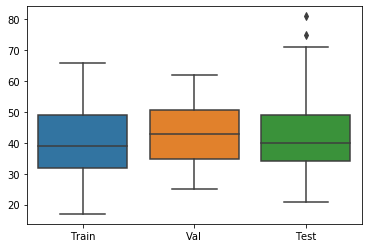

In [10]:
num_caps_tr = list(Counter(list(msvd_tr['clip_id'])).values())
num_caps_va = list(Counter(list(msvd_val['clip_id'])).values())
num_caps_te = list(Counter(list(msvd_te['clip_id'])).values())

ax = sns.boxplot(data=[num_caps_tr,num_caps_va,num_caps_te])
plt.xticks([0,1,2], ('Train','Val','Test'))
plt.show()

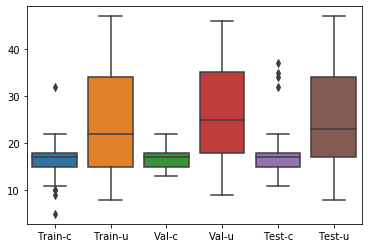

In [11]:
num_caps_tr_clean = list(Counter(list(msvd_tr[msvd_tr['Source']=='clean']['clip_id'])).values())
num_caps_va_clean = list(Counter(list(msvd_val[msvd_val['Source']=='clean']['clip_id'])).values())
num_caps_te_clean = list(Counter(list(msvd_te[msvd_te['Source']=='clean']['clip_id'])).values())

num_caps_tr_unverified = list(Counter(list(msvd_tr[msvd_tr['Source']!='clean']['clip_id'])).values())
num_caps_va_unverified = list(Counter(list(msvd_val[msvd_val['Source']!='clean']['clip_id'])).values())
num_caps_te_unverified = list(Counter(list(msvd_te[msvd_te['Source']!='clean']['clip_id'])).values())

ax = sns.boxplot(data=[num_caps_tr_clean,num_caps_tr_unverified,
                       num_caps_va_clean ,num_caps_va_unverified,
                      num_caps_te_clean,num_caps_te_unverified])
plt.xticks([0,1,2,3,4,5], ('Train-c','Train-u','Val-c','Val-u','Test-c','Test-u'))
# ax.legend(['c clean','u unverify'],loc='best')
plt.show()

# clean captions and count the distribution of their length

In [12]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [13]:
TOKENS_SAVE_PATH = '/home/daic/VideoCaption/RecNet/data/MSVD/metadata/'
def get_tokens(df):
    tokens = {}
    for name in set(df['clip_id']):
        tokens[name] = {'clean':[],'unverified':[]}
    for ix in range(len(df)):
        tmp_cap = df.iloc[ix]['Description'].lower()
        tmp_id = df.iloc[ix]['clip_id']
        tmp_cate = df.iloc[ix]['Source']
        tmp_tokens = tokenizer.tokenize(tmp_cap)
        tokens[tmp_id][tmp_cate].append(tmp_tokens)
    return tokens
train_tokens = get_tokens(msvd_tr)
val_tokens = get_tokens(msvd_val)
test_tokens = get_tokens(msvd_te)
# save them
json.dump(train_tokens,open(TOKENS_SAVE_PATH + 'train_tokens.json','w'))
json.dump(val_tokens,open(TOKENS_SAVE_PATH + 'val_tokens.json','w'))
json.dump(test_tokens,open(TOKENS_SAVE_PATH + 'test_tokens.json','w'))

In [14]:
all_length = [[],[],[]]
train_length = [[],[],[]]
val_length = [[],[],[]]
test_length = [[],[],[]]
for split in ['train','val','test']:
    tmp_tokens = locals()[split+'_tokens']
    for vid in tmp_tokens.keys():
        for sent in tmp_tokens[vid]['clean']:
            locals()[split+'_length'][1].append(len(sent))
        for sent in tmp_tokens[vid]['unverified']:
            locals()[split+'_length'][2].append(len(sent))
    locals()[split+'_length'][0] = locals()[split+'_length'][1] + locals()[split+'_length'][2]
all_length = [train_length[0]+val_length[0]+test_length[0],
              train_length[1]+val_length[1]+test_length[1],
              train_length[2]+val_length[2]+test_length[2]] 

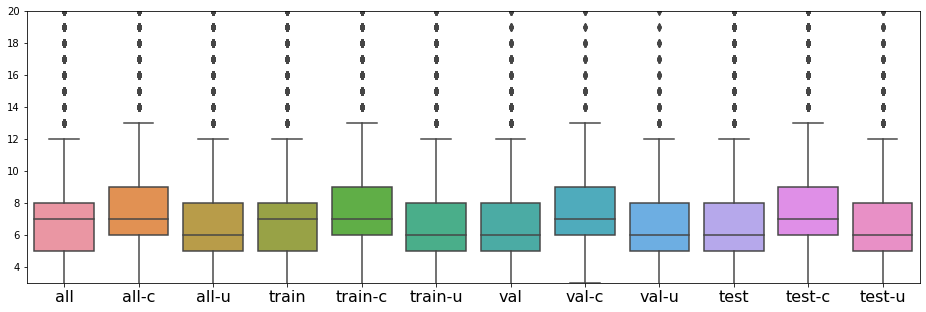

In [15]:
plt.figure(figsize=(16,5))
plt.ylim(3, 20)
ax = sns.boxplot(data=all_length + train_length + val_length +test_length)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], 
           ('all','all-c','all-u',
            'train','train-c','train-u',
            'val','val-c','val-u',
            'test','test-c','test-u'),fontsize=16)
plt.show()

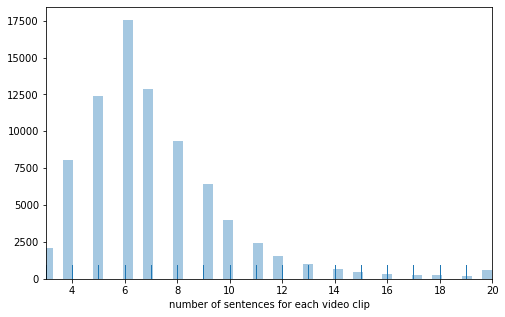

In [16]:
plt.figure(figsize=(8,5))
plt.xlim(3, 20)
np_all_lenth = np.array(all_length[0])
np_all_lenth[np_all_lenth>20] = 20
sns.distplot(np_all_lenth, kde=False, rug=True)
plt.xlabel("number of sentences for each video clip")
plt.show()

## the words distribution and frequency in whole dataset:

In [17]:
counts_tr = {}
for vid in train_tokens.keys():
    for sent in train_tokens[vid]['clean'] + train_tokens[vid]['unverified']:
          for w in sent:
                counts_tr[w] = counts_tr.get(w, 0) + 1
counts_va = {}
for vid in val_tokens.keys():
    for sent in val_tokens[vid]['clean'] + val_tokens[vid]['unverified']:
          for w in sent:
                counts_va[w] = counts_va.get(w, 0) + 1
counts_te = {}
for vid in test_tokens.keys():
    for sent in test_tokens[vid]['clean'] + test_tokens[vid]['unverified']:
          for w in sent:
                counts_te[w] = counts_te.get(w, 0) + 1

### check test/val words not in train set:

In [18]:
tr_ws = counts_tr.keys()
te_ws = counts_te.keys()
va_ws = counts_va.keys()

test_val_w_not_in_train = []
train_w_not_in_test_val = []
for w in list(te_ws)+list(va_ws):
    if w not in tr_ws:
        test_val_w_not_in_train.append(w)
for w in tr_ws:
    if w not in list(te_ws)+list(va_ws):
        train_w_not_in_test_val.append(w)
        
print("%d train words not in test/val set."%len(train_w_not_in_test_val))
print(train_w_not_in_test_val[:10])
print("%d test/val words not in train set."%len(test_val_w_not_in_train))
print(test_val_w_not_in_train[:10])

4860 train words not in test/val set.
['guitasr', 'ben', 'williams', 'blinding', 'slime', 'dumped', 'slimed', 'goo', 'doused', '1984']
3203 test/val words not in train set.
['motorcylist', 'wrecking', 'slipped', 'stnat', 'spectacular', 'stun', 'thrased', 'pottato', 'chikken', 'chimps']


### only processing training set!!

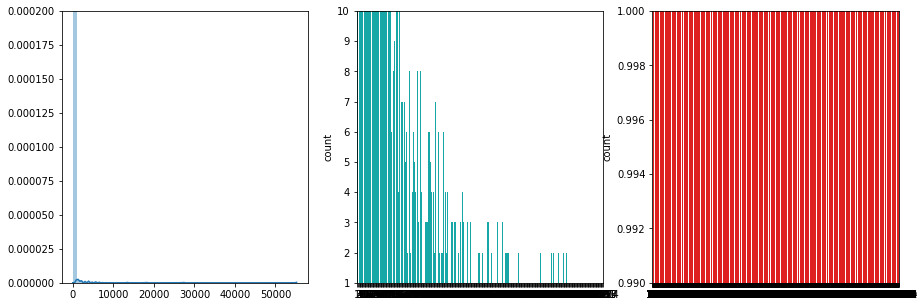

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.distplot(list(counts_tr.values()), ax =ax1).set_ylim(0,0.0002)
sns.countplot(list(counts_tr.values()),color="c" ,ax =ax2).set_ylim(1,10)
consum = np.cumsum(np.sort(np.array(list(counts_tr.values()))))
sns.countplot(consum, color="r" ,ax =ax3).set_ylim(0.99,1.)
plt.show()

In [26]:
cou_tr = np.array(list(counts_tr.values()))
for num_appear in range(10):
    print("words' number which appearence > %2d : %4d"%(num_appear,np.sum(cou_tr>num_appear)))

words' number which appearence >  0 : 9499
words' number which appearence >  1 : 5376
words' number which appearence >  2 : 4146
words' number which appearence >  3 : 3483
words' number which appearence >  4 : 3032
words' number which appearence >  5 : 2744
words' number which appearence >  6 : 2519
words' number which appearence >  7 : 2320
words' number which appearence >  8 : 2148
words' number which appearence >  9 : 2008


In [47]:
counts_te['monkey']

227

In [43]:
'braid' in va_ws

False

# MSR-VTT

## train/val:each video has 20 sentences

## train/val sentences length

In [28]:
msrvtt_tv = json.load(open('/home/daic/VideoCaption/RecNet/data/MSR-VTT/metadata/train_val_videodatainfo.json'))
msrvtt_len = []
tokens_vtt = []
for sent in msrvtt_tv['sentences']:
    tmp_cap = sent['caption']
    tmp_token = tokenizer.tokenize(tmp_cap)
    tokens_vtt.append(tmp_token)
    msrvtt_len.append(len(tmp_token))

In [51]:
np_msrvtt_len = np.array(msrvtt_len)
for max_length in range(12,30):
    print("sentences' length > %2d : %5d"%(max_length,np.sum(np_msrvtt_len>max_length)))

sentences' length > 12 : 24648
sentences' length > 13 : 18943
sentences' length > 14 : 14608
sentences' length > 15 : 11288
sentences' length > 16 :  8720
sentences' length > 17 :  6841
sentences' length > 18 :  5360
sentences' length > 19 :  4174
sentences' length > 20 :  3262
sentences' length > 21 :  2505
sentences' length > 22 :  1960
sentences' length > 23 :  1543
sentences' length > 24 :  1203
sentences' length > 25 :   918
sentences' length > 26 :   691
sentences' length > 27 :   538
sentences' length > 28 :   419
sentences' length > 29 :   324


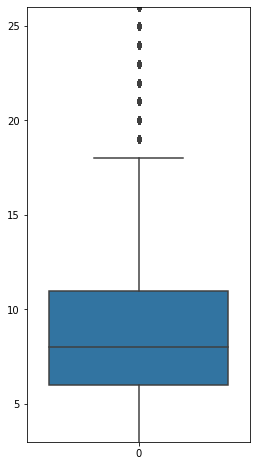

In [29]:
plt.figure(figsize=(4,8))
plt.ylim(3, 26)
ax = sns.boxplot(data=msrvtt_len)
plt.show()

In [30]:
counts_tr_vtt = {}
for sent in tokens_vtt:
      for w in sent:
            counts_tr_vtt[w] = counts_tr_vtt.get(w, 0) + 1

In [44]:
counts_tr_vtt['braid']

12

In [32]:
cou_tr_vtt = np.array(list(counts_tr_vtt.values()))
for num_appear in range(10):
    print("words' number which appearence > %2d : %4d"%(num_appear,np.sum(cou_tr_vtt>num_appear)))

words' number which appearence >  0 : 23463
words' number which appearence >  1 : 13982
words' number which appearence >  2 : 10861
words' number which appearence >  3 : 9195
words' number which appearence >  4 : 8098
words' number which appearence >  5 : 7275
words' number which appearence >  6 : 6629
words' number which appearence >  7 : 6117
words' number which appearence >  8 : 5717
words' number which appearence >  9 : 5333
